In [1]:
import numpy as np
import scipy.integrate as sci
import scipy.optimize as sco
import theano.tensor as T
import theano
import downhill
import climate
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

KeyError: 'QtAgg'

Details for gaussian distribution as an exponential family

In [2]:
def s_1(x):
    return x

def s_2(x):
    return -x*x

def F_1D(theta1,theta2):
    return 0.25*theta1*theta1/theta2 + 0.5*np.log(np.pi) - 0.5*np.log(theta2) 

def gradF_1_1D(theta_1,theta_2):
    return 0.5*theta_1/theta_2

def gradF_2_1D(theta_1, theta_2):
    temp_1 = 0.5 / theta_2
    temp_2 = temp_1 * theta_1
    return -1. * (temp_2 * temp_2 + temp_1)

def gradF_1_nD(theta_1,theta_2):
    return 0.5*np.dot(np.inv(theta_2), theta_1)

def gradF_2_nD(theta_1, theta_2):
    temp_1 = 0.5*np.inv(theta_2)
    temp_2 = np.dot(temp1,theta_1)
    return - np.outer(temp_2,temp_2) - temp_1

Cas 1D - Data

In [3]:
seed = 13
np.random.seed(seed)
N, batch_size = 2000, 100
mu_true, sigma_true = 1, 2
sigma2_true = sigma_true*sigma_true
theta1_true = mu_true / sigma2_true
theta2_true = 0.5 / sigma2_true
eta1_true = mu_true
eta2_true = - (mu_true*mu_true + sigma2_true)


X = np.random.normal(mu_true,np.sqrt(sigma2_true), N)

def batches(Y, bs):
    nb = np.int(np.ceil(len(Y) / bs))
    Yb = [Y[i * bs : (i+1) * bs] for i in range(nb)]
    def __temp(i):
        return Yb[i]
    return nb, Yb, __temp

Xt = X[: N//4]
Nt = len(Xt)
NtB, XtB, XtB_f = batches(Xt, batch_size)
Xv = X[N//4 : N//2]
Nv = len(Xv)
NvB, XvB, XvB_f = batches(Xv, batch_size)
Xtest = X[N//2:]
# print (Xt, XtB, NtB, XtB_f(1))

In [4]:
def ll(x, mu, sigma2):
    return -(x - mu)**2 /(2 * sigma2) - np.log(np.sqrt(2 * sigma2 * np.pi)) 

def ll_theta(x, theta1, theta2):
    return s_1(x) * theta1 + s_2(x) * theta2 - F_1D(theta1, theta2)

def ll_eta(x, eta1, eta2):
    theta1 = - eta1 / (eta1*eta1 + eta2)
    theta2 = - 0.5  / (eta1*eta1 + eta2)
    return ll_theta(x, theta1, theta2)
    

def ave_ll(mu, sigma2, chi):
    N = len(chi)
    return (1 / N) * sum(ll(x, mu, sigma2) for x in chi)
    
def C_N(mu, sigma2, chi):
    return -ave_ll(mu, sigma2, chi)

np.testing.assert_allclose(ll(4, mu_true, sigma2_true),
                          ll_theta(4, theta1_true, theta2_true))
np.testing.assert_allclose(ll(4, mu_true, sigma2_true),
                          ll_eta(4, eta1_true, eta2_true))

# Points stationnaires de $C(\theta) = \mathbb{E}_{\pi} [C(\theta,x)] = \mathbb{E}_{\pi} [-\log p(x;\theta)]$ par Robbins-Monro


### Robbins-Monro

On dispose d'une fonction inconnue (supposée monotone) $M(\theta)$ telle que 
$$M(\theta) = \mathbb{E}_{\pi(\beta|\theta)} [\beta]$$ 
avec $\beta$ une v.a désignant des observations bruitées de $M(\theta)$.

On cherche la valeur $\theta^*$ telle que $M(\theta^*) = \alpha$.

Suite convergente de Robbins-Monro : $$\theta^{(t+1)} - \theta^{(t)} = a^{(t)} (\alpha - \beta^{(t)})$$

### Robbins-Monro  et gradient stochastique

$M(\theta) := \nabla_{\theta} C(\theta)$ est le gradient d'une fonction inconnue $C$. 

On cherche la valeur $\theta^*$ telle que $M(\theta^*) = \nabla C(\theta^*) = 0$.

Suite convergente de Robbins-Monro : $$\theta^{(t+1)} = \theta^{(t)} - a^{(t)} \beta^{(t)}$$
où $\beta^{(t)}$ est une observation bruitée de $\nabla_{\theta} C(\theta^{(t)})$.

### Pour notre cas
La fonction à minimiser est:
$$C(\theta) = \mathbb{E}_{\pi} [- \log p(x;\theta)]$$
où $\pi$ est la distribution inconnue dont on cherche une approximation $p$ paramétrée par $\theta$ (identique à la minimisation sur $\theta$ de $KL(\pi || p(.;\theta))$)

Son équivalent en discret:
$$C_N(\theta) = - N^{-1} \sum_i \log p(x_i;\theta)$$
avec $\lim_{N \rightarrow +\infty} C_N(\theta) = C(\theta)$ 

Sous conditions de regularité et dans la famille exponentielle, 
$$\nabla_{\theta} C(\theta) = \mathbb{E}_{\pi} [- \nabla_{\theta}\log p(x;\theta)]  = \mathbb{E}_{\pi} [- s(x) + \nabla_{\theta} F (\theta)] = - \mathbb{E}_{\pi} [s(x)] + \nabla_{\theta} F (\theta)$$

Dans l'espace $H$ (paramètre d'espérance), une formulation équivalente est la suivante :
$$\eta^* = \mathbb{E}_{\pi} [s(x)]$$

Pour le relier à Robbin-Monro, on a une observation bruitée
$$\beta^{(t)} = - s(x^{(t)}) + \nabla_{\theta} F (\theta^{(t)})$$
et donc la suite convergente $$\theta^{(t+1)} = \theta^{(t)} + a^{(t)} (s(x^{(t)}) - \nabla_{\theta} F (\theta^{(t)}))$$


## Points stationnaires de $C_N(\theta)$ par dérivation exacte

   $$\nabla C_N(\theta) = 0 \equiv -N^{-1} \sum_i (s(x_i) - \nabla F(\theta)) = 0 \equiv  \nabla F(\theta) = N^{-1} \sum_i s(x_i)$$

In [5]:
gradF_pt_stat_1 = np.sum(s_1(x) for x in Xt) / Nt
gradF_pt_stat_2 = np.sum(s_2(x) for x in Xt) / Nt
pt_stat = gradF_pt_stat_1, - gradF_pt_stat_1**2 - gradF_pt_stat_2
print ((mu_true, sigma2_true), ' vs ', pt_stat)
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(pt_stat[0], pt_stat[1], Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(pt_stat[0], pt_stat[1], Xtest))

(1, 4)  vs  (0.93141726306687489, 3.5299590612896603)
average ll on training set :  -2.0539185454  vs  -2.04958166996
average ll on test set :  -2.10152922778  vs  -2.10479830458


# Optimization via scipy

In [6]:
def fun_C_N(mu_sigma2):
    return C_N(mu_sigma2[0], mu_sigma2[1], Xt)
np.random.rand(seed)
x0 = (np.random.randn(), np.random.random())
bnds = ((-np.inf, np.inf), (1e-6, np.inf))   # variance is positive
res_C_N = sco.minimize(fun_C_N, x0, bounds=bnds) #, options={'gtol': 1e-6, 'disp': True})
print(res_C_N)
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(res_C_N.x[0], res_C_N.x[1], Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(res_C_N.x[0], res_C_N.x[1], Xtest))

      fun: 2.049581669969299
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.06581410e-06,  -7.10542736e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 45
      nit: 13
   status: 0
  success: True
        x: array([ 0.93142087,  3.52993911])
average ll on training set :  -2.0539185454  vs  -2.04958166997
average ll on test set :  -2.10152922778  vs  -2.10479855013


## Optimization via Stochastic Gradient Descent  (natural space)
mostly fail:
- $\alpha = 0.01$

success:
- $\alpha = 0.001$

In [7]:
np.random.seed(seed)

alpha = 0.01
epochs = 10

mu_0, sigma2_0 = np.random.randn(), np.random.random()
theta1, theta2 = mu_0 / sigma2_0, 0.5 / sigma2_0

def grad_nll_1(x, theta1, theta2):
    return - (s_1(x) - gradF_1_1D(theta1, theta2))

def grad_nll_2(x, theta1, theta2):
    return - (s_2(x) - gradF_2_1D(theta1, theta2))
    
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for __ in range(epochs):
    for xt in Xt:
        #print("avant theta",theta1, theta2, " x ", xt)
        #print ("grad 1 ", gradF_1_1D(theta1, theta2), grad_nll_1(xt, theta1, theta2))
        #print ("grad 2 ", gradF_2_1D(theta1, theta2), grad_nll_2(xt, theta1, theta2))
        theta1 -= alpha*grad_nll_1(xt, theta1, theta2)
        theta2 -= alpha*grad_nll_2(xt, theta1, theta2)
        #print("apres theta", theta1, theta2)
        mu_est, sigma2_est = 0.5*theta1/theta2, 0.5/theta2
        #print("apres mu_sd2",   mu_est, sigma2_est)
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest))  

[-0.11939673470137332, -0.11936730809934622, -0.11936734771730743] [-0.0023083924900336493, -0.0023082635619259819, -0.0023082633700631464]
average ll on training set :  -2.0539185454  vs  nan
average ll on test set :  -2.10152922778  vs  nan


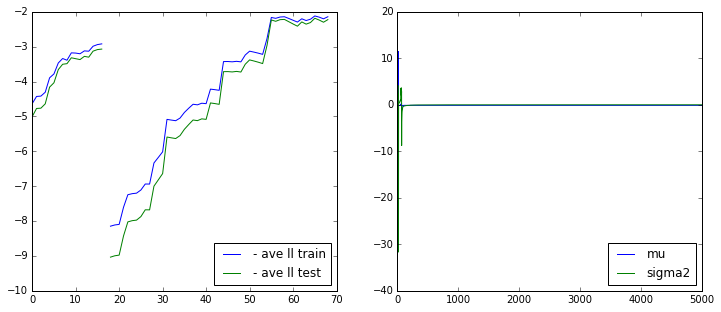

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(ave_ll_list_train, label='- ave ll train')
axes[0].plot(ave_ll_list_test, label='- ave ll test')
axes[0].legend(loc=4)
axes[1].plot(mu_list, label='mu')
axes[1].plot(sig_list, label = 'sigma2')
axes[1].legend(loc=4)
print(mu_list[-3:], sig_list[-3:])
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(mu_est, sigma2_est, Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(mu_est, sigma2_est, Xtest))


## Optimization via Stochastic Gradient Descent  

Il s'agit d'un réécriture simple en remplacant $\nabla F$ par $\eta$. 

Cela ressemble dans la forme à l'approximation stochastique du Online EM.

L'algorihme converge car les deux optimisations (avec celles du dessus) sont liées. 

(J'ai fait le calcul $\eta^{(n+1)} - \eta^{(n)}$ vers $\theta^{(n+1)} - \theta^{(n)}$)

Il ne correspond pas à un SGD dand $H$.

In [9]:
np.random.seed(seed)

alpha = 0.001
epochs = 10
mu_0, sigma2_0 = np.random.randn(), np.random.random()
eta1, eta2 = mu_0 , -(mu_0*mu_0 + sigma2_0)
def grad_nll_1(x, eta1, eta2):
    return -(s_1(x) - eta1)

def grad_nll_2(x, eta1, eta2):
    return -(s_2(x) - eta2)
    
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for __ in range(epochs):
    for x in Xt:
        #print("avant eta",eta1, eta2, " x ", x)
        #print ("grad 1 ", grad_nll_1(x, eta1, eta2))
        #print ("grad 2 ", grad_nll_2(x, eta1, eta2))
        eta1 -= alpha*grad_nll_1(x, eta1, eta2)
        eta2 -= alpha*grad_nll_2(x, eta1, eta2)
        #print("apres eta", eta1, eta2)
        mu_est, sigma2_est = eta1, -(eta1*eta1+eta2)
        #print("apres mu_sd2", mu_est, sd_est)
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest))  

[0.91961235104472128, 0.91758740309757492, 0.91655259457865734] [3.539418723260173, 3.5399756183113764, 3.5375054005352187]
average ll on training set :  -2.0539185454  vs  -2.04961404007
average ll on test set :  -2.10152922778  vs  -2.10498674198


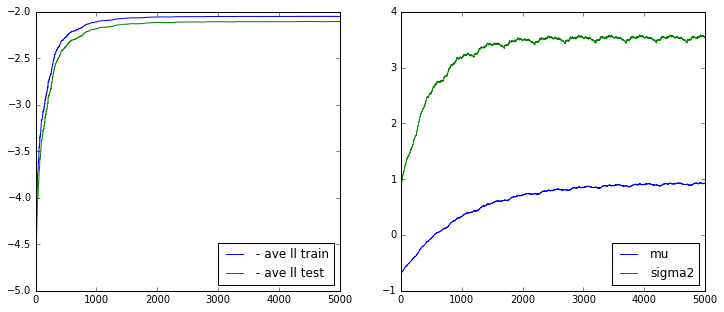

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(ave_ll_list_train, label='- ave ll train')
axes[0].plot(ave_ll_list_test, label='- ave ll test')
axes[0].legend(loc=4)
axes[1].plot(mu_list, label='mu')
axes[1].plot(sig_list, label = 'sigma2')
axes[1].legend(loc=4)
print(mu_list[-3:], sig_list[-3:])
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(mu_est, sigma2_est, Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(mu_est, sigma2_est, Xtest))

# Theano

In [11]:
def gradient_updates(cost, params, alpha):
    updates = [(param, param - alpha*T.grad(cost, param)) for param in params]
    return updates

def gradient_updates_momentum(cost, params, alpha, momentum):
    """
    http://caffe.berkeleyvision.org/tutorial/solver.html
    """
    assert momentum < 1 and momentum >= 0
    updates = []
    for param in params:
        V = theano.shared(param.get_value()*0.)
        updates.append((param, param + V))
        updates.append((V, momentum*V - alpha * T.grad(cost, param)))
    return updates

# on peut rajouter d'autres méthodes ici

def gradient_updates_adam(cost, params, alpha, beta1, beta2):
    assert beta1 < 1 and beta1 >= 0
    assert beta2 < 1 and beta2 >= 0
    updates = []
    t = theano.shared(1.)
    updates.append((t, t+1))
    for param in params:
        gt = T.grad(cost, param) 
        mt = theano.shared(0.)
        updates.append((mt, beta1 * mt + (1-beta1) * gt))
        vt = theano.shared(0.)
        updates.append((vt, beta2 * vt + (1-beta2) * gt * gt))
        alpha_t = theano.shared(0.)
        updates.append((alpha_t, 
                        alpha*T.sqrt(1 - beta2**t)/(1 - beta1**t)))
        updates.append((param, param - alpha_t*mt/(T.sqrt(vt + 1e-8))))
    return updates   

## Optimization SGD via Theano (source space)

In [12]:
np.random.seed(seed)

alpha = 0.001
epochs = 10
# Declare Theano symbolic variables
x = T.scalar()
mu_0, sigma2_0 = np.random.randn(), np.random.random()
mu = theano.shared(mu_0, name="mu")
sigma2 = theano.shared(sigma2_0, name="sigma2") # ensure initial value is positive

# Construct Theano expression graph to minimize (- log-likehood for univariate gaussian)
nll =  (x - mu)**2 /(2 * sigma2) + T.log(T.sqrt(2 * sigma2 *np.pi))

# Compile
train = theano.function(
          inputs=[x],
          updates=gradient_updates(nll, [mu, sigma2], alpha))

# Train
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for i in range(epochs):
    for xt in Xt:
        __ = train(xt)
        mu_est, sigma2_est = mu.get_value(), sigma2.get_value()
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest)) 

[array(0.8017164478011926), array(0.8009380976414321), array(0.8005633723980897)] [array(2.450120964181179), array(2.450219807109778), array(2.4500859532891113)]
average ll on training set :  -2.0539185454  vs  -2.09086893649
average ll on test set :  -2.10152922778  vs  -2.17390299339


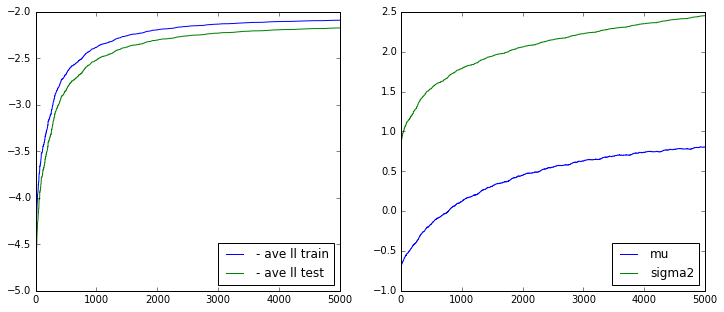

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(ave_ll_list_train, label='- ave ll train')
axes[0].plot(ave_ll_list_test, label='- ave ll test')
axes[0].legend(loc=4)
axes[1].plot(mu_list, label='mu')
axes[1].plot(sig_list, label = 'sigma2')
axes[1].legend(loc=4)
print(mu_list[-3:], sig_list[-3:])
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(mu_est, sigma2_est, Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(mu_est, sigma2_est, Xtest))

# Optimization SGD via Theano (natural space)

Fails for $\alpha =0.005$

In [14]:
np.random.seed(seed)

alpha = 0.001
epochs = 10

# Declare Theano symbolic variables
x = T.scalar()

mu_0, sigma2_0 = np.random.randn(), np.random.random() 
theta1 = theano.shared(mu_0 / sigma2_0, name="theta1") # ensure initial value is positive
theta2 = theano.shared(0.5 / sigma2_0, name="theta2") # ensure initial value is positive

# Construct Theano expression graph to minimize (- log-likehood for univariate gaussian)
nll_theta =  -(x*theta1 - theta2*x*x - 0.25*theta1*theta1/theta2 - 0.5*np.log(np.pi) +0.5*T.log(theta2))

# Compile
train = theano.function(
          inputs=[x],
          updates=gradient_updates(nll_theta, [theta1, theta2], alpha))

# Train
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for i in range(epochs):
    for xt in Xt:
        train(xt)
        mu_est = 0.5*theta1.get_value()/theta2.get_value()
        sigma2_est = 0.5/theta2.get_value()
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest))

[0.7556801384616143, 0.74041433136638446, 0.72367433502693956] [2.922011337064915, 2.8837340603265189, 2.8279820960377546]
average ll on training set :  -2.0539185454  vs  -2.07046331225
average ll on test set :  -2.10152922778  vs  -2.14417369816


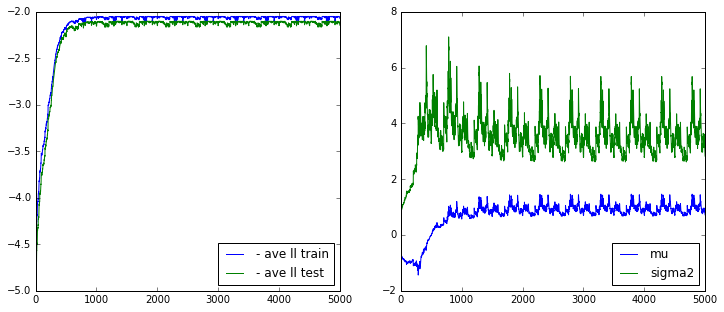

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(ave_ll_list_train, label='- ave ll train')
axes[0].plot(ave_ll_list_test, label='- ave ll test')
axes[0].legend(loc=4)
axes[1].plot(mu_list, label='mu')
axes[1].plot(sig_list, label = 'sigma2')
axes[1].legend(loc=4)
print(mu_list[-3:], sig_list[-3:])
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(mu_est, sigma2_est, Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(mu_est, sigma2_est, Xtest))

# Optimization SGD via Theano (expectation space)

In [16]:
np.random.seed(seed)

alpha = 0.001
epochs = 10

# Declare Theano symbolic variables
x = T.scalar()

mu_0, sigma2_0 = np.random.randn(), np.random.random()
eta1 = theano.shared(mu_0, name="eta1") # ensure initial value is positive
eta2 = theano.shared(-(mu_0*mu_0 + sigma2_0), name="eta2") # ensure initial value is positive
print(eta1.get_value(), eta2.get_value())
# Construct Theano expression graph to minimize (- log-likehood for univariate gaussian)
theta1 = - eta1 / (eta1*eta1 + eta2)
theta2 = - 0.5  / (eta1*eta1 + eta2)
nll_eta =  -(x*theta1 - theta2*x*x - 0.25*theta1*theta1/theta2 - 0.5*np.log(np.pi) +0.5*T.log(theta2))

# Compile
train = theano.function(
          inputs=[x],
          updates=gradient_updates(nll_eta, [eta1, eta2], alpha))

# Train
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for i in range(epochs):
    for xt in Xt:
        train(xt)
        # print(g1, s_1(xt) - eta1.get_value())
        # print(g2, s_2(xt) - eta2.get_value())
        mu_est = eta1.get_value()
        sigma2_est = - (eta1.get_value()*eta1.get_value()+eta2.get_value())
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest))

-0.712390662050588 -1.3317789880382436


[array(0.5452658831813467), array(0.5445316661419595), array(0.5444393472775879)] [2.3620602425439818, 2.3628928697407292, 2.3628210142059425]
average ll on training set :  -2.0539185454  vs  -2.12753566168
average ll on test set :  -2.10152922778  vs  -2.22070094989


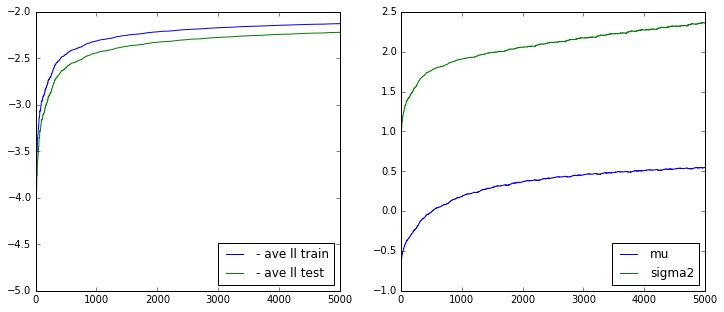

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(ave_ll_list_train, label='- ave ll train')
axes[0].plot(ave_ll_list_test, label='- ave ll test')
axes[0].legend(loc=4)
axes[1].plot(mu_list, label='mu')
axes[1].plot(sig_list, label = 'sigma2')
axes[1].legend(loc=4)
print(mu_list[-3:], sig_list[-3:])
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(mu_est, sigma2_est, Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(mu_est, sigma2_est, Xtest))

## Optimization via Theano +  SGD Nesterov momemtum (Source space)

In [18]:
np.random.seed(seed)

alpha = 0.01
momentum = 0.9
epochs = 10
# Declare Theano symbolic variables
x = T.scalar()
mu_0, sigma2_0 = np.random.randn(), np.random.random()
mu = theano.shared(mu_0, name="mu")
sigma2 = theano.shared(sigma2_0, name="sigma2") # ensure initial value is positive

# Construct Theano expression graph to minimize (- log-likehood for univariate gaussian)
nll =  (x - mu)**2 /(2 * sigma2) + T.log(T.sqrt(2 * sigma2 *np.pi))

# Compile
train = theano.function(
          inputs=[x],
          updates=gradient_updates_momentum(nll, [mu, sigma2], alpha, momentum))

# Train
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for i in range(epochs):
    for xt in Xt:
        train(xt)
        mu_est, sigma2_est = mu.get_value(), sigma2.get_value()
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest)) 

[array(0.9008664759954013), array(0.8862573597413593), array(0.8676274283958625)] [array(3.6597995042819806), array(3.655930001588331), array(3.6525837204948752)]
average ll on training set :  -2.0539185454  vs  -2.05042693243
average ll on test set :  -2.10152922778  vs  -2.10492803034


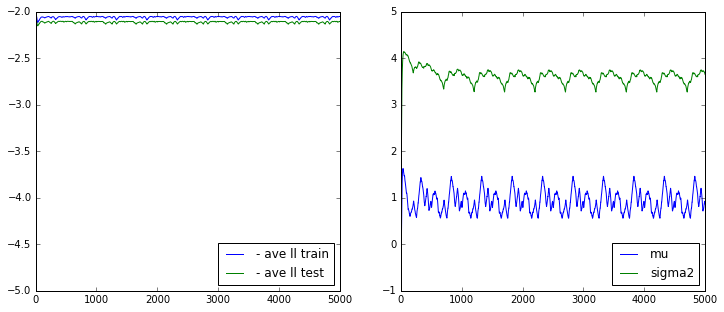

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(ave_ll_list_train, label='- ave ll train')
axes[0].plot(ave_ll_list_test, label='- ave ll test')
axes[0].legend(loc=4)
axes[1].plot(mu_list, label='mu')
axes[1].plot(sig_list, label = 'sigma2')
axes[1].legend(loc=4)
print(mu_list[-3:], sig_list[-3:])
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(mu_est, sigma2_est, Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(mu_est, sigma2_est, Xtest))

## Optimization via Theano +  ADAM (Source space)

In [20]:
np.random.seed(seed)

alpha = 0.005
beta1 = 0.9
beta2 = 0.995
epochs = 10
# Declare Theano symbolic variables
x = T.scalar()
mu_0, sigma2_0 = np.random.randn(), np.random.random()
mu = theano.shared(mu_0, name="mu")
sigma2 = theano.shared(sigma2_0, name="sigma2") # ensure initial value is positive

# Construct Theano expression graph to minimize (- log-likehood for univariate gaussian)
nll =  (x - mu)**2 /(2 * sigma2) + T.log(T.sqrt(2 * sigma2 *np.pi))

# Compile
train = theano.function(
          inputs=[x],
          updates=gradient_updates_adam(nll, [mu, sigma2], 
                                        alpha, beta1, beta2))

# Train
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for i in range(epochs):
    for xt in Xt:
        train(xt)
        mu_est, sigma2_est = mu.get_value(), sigma2.get_value()
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest)) 

[array(0.9421437857287461), array(0.9405724665804894), array(0.9386189279289024)] [array(3.4866436072449463), array(3.4858632356785337), array(3.4852242082767892)]
average ll on training set :  -2.0539185454  vs  -2.04962994941
average ll on test set :  -2.10152922778  vs  -2.1054206519


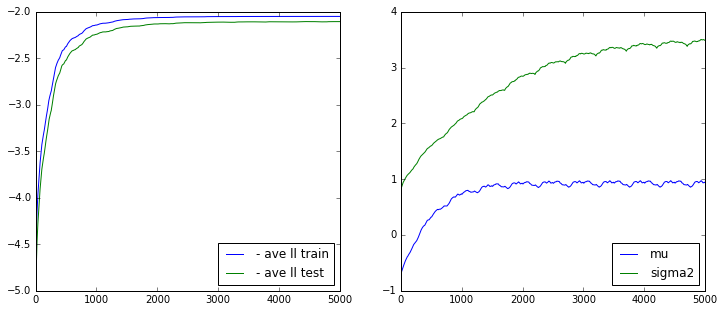

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(ave_ll_list_train, label='- ave ll train')
axes[0].plot(ave_ll_list_test, label='- ave ll test')
axes[0].legend(loc=4)
axes[1].plot(mu_list, label='mu')
axes[1].plot(sig_list, label = 'sigma2')
axes[1].legend(loc=4)
print(mu_list[-3:], sig_list[-3:])
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(mu_est, sigma2_est, Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(mu_est, sigma2_est, Xtest))

# Optimization via downhill (adam)

Pas encore terminé...

In [22]:
climate.enable_default_logging()

np.random.seed(seed)

alpha = 0.01
momentum = 0.9
epochs = 10
# Declare Theano symbolic variables
x = T.vector()
mu_0, sigma2_0 = np.random.randn(), np.random.random()
mu = theano.shared(mu_0, name="mu")
sigma2 = theano.shared(sigma2_0, name="sigma2") # ensure initial value is positive

# Construct Theano expression graph to minimize (- log-likehood for univariate gaussian)
#nll =  (x - mu)**2 /(2 * sigma2) + T.log(T.sqrt(2 * sigma2 *np.pi))
navell =  T.sum(T.sqr(x - mu) /(2 * sigma2) + T.log(T.sqrt(2 * sigma2 *np.pi)))
train = downhill.Dataset(Xt)
#valid = downhill.Dataset(Xtest)

downhill.minimize(
    loss=navell,
    train=Xt,
    patience=0,
    max_gradient_norm=1,          # Prevent gradient explosion!
    learning_rate=alpha)


print(mu.get_value())
print(sigma2.get_value())

INFO:downhill.dataset:dataset0: 16 of 16 mini-batches from (500,)


I 2016-02-14 09:38:30 downhill.dataset:174 dataset0: 16 of 16 mini-batches from (500,)


INFO:downhill.dataset:train: 16 of 16 mini-batches from (500,)


I 2016-02-14 09:38:30 downhill.dataset:174 train: 16 of 16 mini-batches from (500,)


INFO:downhill.base:-- patience = 0


I 2016-02-14 09:38:30 downhill.base:389 -- patience = 0


INFO:downhill.base:-- validate_every = 10


I 2016-02-14 09:38:30 downhill.base:390 -- validate_every = 10


INFO:downhill.base:-- max_updates = None


I 2016-02-14 09:38:30 downhill.base:391 -- max_updates = None


INFO:downhill.base:-- min_improvement = 0


I 2016-02-14 09:38:30 downhill.base:392 -- min_improvement = 0


INFO:downhill.base:-- max_gradient_norm = 1


I 2016-02-14 09:38:30 downhill.base:393 -- max_gradient_norm = 1


INFO:downhill.base:-- max_gradient_elem = 0


I 2016-02-14 09:38:30 downhill.base:394 -- max_gradient_elem = 0


INFO:downhill.base:-- learning_rate = 0.01


I 2016-02-14 09:38:30 downhill.base:395 -- learning_rate = 0.01


INFO:downhill.base:-- momentum = 0


I 2016-02-14 09:38:30 downhill.base:396 -- momentum = 0


INFO:downhill.base:-- nesterov = False


I 2016-02-14 09:38:30 downhill.base:397 -- nesterov = False


INFO:downhill.adaptive:-- rms_halflife = 14


I 2016-02-14 09:38:30 downhill.adaptive:220 -- rms_halflife = 14


INFO:downhill.adaptive:-- rms_regularizer = 1e-08


I 2016-02-14 09:38:30 downhill.adaptive:221 -- rms_regularizer = 1e-08


INFO:downhill.base:compiling evaluation function


I 2016-02-14 09:38:30 downhill.base:118 compiling evaluation function


INFO:downhill.base:compiling RMSProp function


I 2016-02-14 09:38:30 downhill.base:124 compiling RMSProp function


TypeError: No suitable SharedVariable constructor could be found. Are you sure all kwargs are supported? We do not support the parameter dtype or type. value="0.0". parameters="{'broadcastable': ()}"

In [ ]:
help(downhill.minimize)

## L'exemple de la doc de downhill ne marche pas

In [ ]:
climate.enable_default_logging()


import theano.tensor as TT
def rand(a, b): return np.random.randn(a, b).astype('f')

A, B, K = 20, 5, 3

# Set up a matrix factorization problem to optimize.
u = theano.shared(rand(A, K), name='u')
v = theano.shared(rand(K, B), name='v')
e = TT.sqr(TT.matrix() - TT.dot(u, v))

# Minimize the regularized loss with respect to a data matrix.
y = np.dot(rand(A, K), rand(K, B)) + rand(A, B)

downhill.minimize(
    loss=e.mean() + abs(u).mean() + (v * v).mean(),
    train=[y],
    patience=0,
    batch_size=A,                 # Process y as a single batch.
    max_gradient_norm=1,          # Prevent gradient explosion!
    learning_rate=0.1,
    monitors=(('err', e.mean()),  # Monitor during optimization.
              ('|u|<0.1', (abs(u) < 0.1).mean()),
              ('|v|<0.1', (abs(v) < 0.1).mean())),
    monitor_gradients=True)

# Print out the optimized coefficients u and basis v.
print('u =', u.get_value())
print('v =', v.get_value())